In [17]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import ipywidgets as widgets  # not used, for future
from IPython.display import display
import nglview as nv
from io import StringIO
import time
import pandas as pd

In [18]:
def pos2pdb(positions):
    pdb_str = "MODEL\n"
    for i, pos in enumerate(positions):
        pdb_str += f"ATOM  {i+1:5d}  CA  ALA A{i+1:4d}    {pos[0]:8.3f}{pos[1]:8.3f}{0.0:8.3f}  1.00  0.00           C  \n"
    pdb_str += "ENDMDL\n"
    return pdb_st

In [19]:
start_time = time.time()
id = 24094014
def student_id_to_initial_T(id):
 r = id % 10000000
 return (r / 10000000) * 6 + 1
T = student_id_to_initial_T(id)
N = 100  # Number of atoms
d = 2  # a 2D system
rho = 0.8  # The (reduced units) density (in 2D)
T0 = T  # Reduced temperature (in reduced units)
Ti = T0  # Initial Temperature (in reduced units)
# the Interatomic Potential (a special case of a Materials Relation)
epsilon = 1.0
sigma = 1.0
dt = 0.0025
max_steps = 2000
print(T0,T)

3.4564084 3.4564084


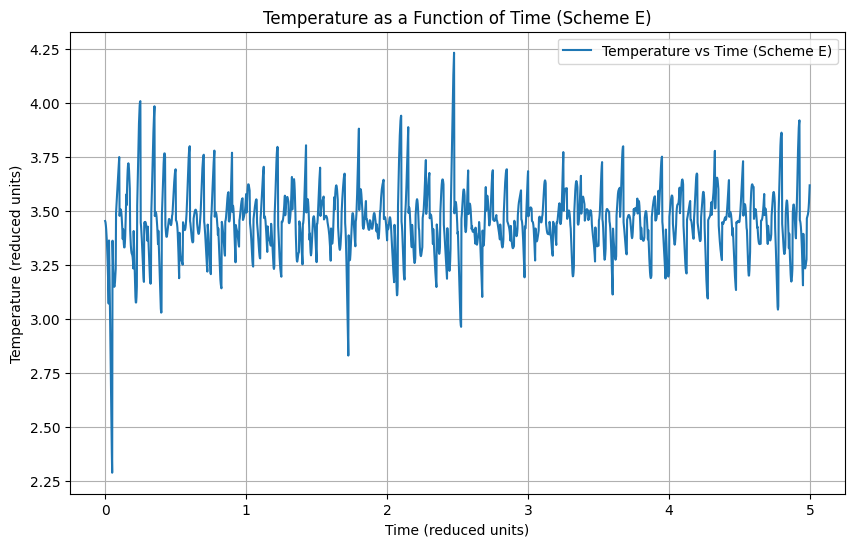

In [20]:
# 初始化温度目标和波动范围

temperature_tolerance = 0.3  # 温度稳定波动范围
stable_steps_required = 50  # 需要连续多少步在范围内才认为温度稳定

# 存储温度稳定的步数
stable_steps_count = 0
temperature_stabilized = False  # 标记系统温度是否已经稳定



# 初始化粒子位置和速度
L = np.sqrt(N / rho)
a = L / np.sqrt(N)
positions = []
for i in range(int(np.sqrt(N))):
    for j in range(int(np.sqrt(N))):
        x = i * a
        y = j * a
        positions.append([x, y])

positions = np.array(positions)
velocities = np.random.randn(N, d)
m = 1
k_B = 1

# 重标度初始速度
v_s = np.sum(velocities**2, axis=1)
ke = 0.5 * np.sum(v_s)
ke_target = N * T0
scaling_factor = np.sqrt(ke_target / ke)
velocities *= scaling_factor

# 定义温度计算函数
def calculate_temperature(velocities, m, k_B):
    v_squared = np.sum(velocities**2, axis=1)
    ke = 0.5 * np.sum(v_squared)
    temperature = (2 * ke) / (d * N * k_B)
    return temperature

# 计算力的函数
def compute_force(positions, epsilon, sigma):
    forces = np.zeros_like(positions)
    pot_energy = 0

    for i in range(N):
        for j in range(i + 1, N):
            rij = positions[i] - positions[j]
            rij = rij - np.round(rij / L) * L
            r = np.sqrt(rij.dot(rij))
            if r < 0.2:
                r = 0.2
            force2 = 48 * epsilon * np.power(sigma, 12) / np.power(r, 13) - 24 * epsilon * np.power(sigma, 6) / np.power(r, 7)
            force = force2 * rij / r
            forces[i] += force
            forces[j] -= force

            pe = 4 * epsilon * (np.power(sigma / r, 12) - np.power(sigma / r, 6))
            pot_energy = pot_energy + pe

    return forces, pot_energy

# 计算动能和温度的函数
def compute_kinetic_energy(velocities):
    kinetic_energy = 0.5 * np.sum(velocities**2)
    temperature = kinetic_energy / N
    return kinetic_energy, temperature

# 更新粒子位置和速度的函数
def update_positions(positions, velocities, forces, epsilon, sigma, dt):
    positions += velocities * dt + 0.5 * forces * dt ** 2
    positions %= L
    new_forces, pot_energy = compute_force(positions, epsilon, sigma)
    velocities += 0.5 * (forces + new_forces) * dt
    return positions, velocities, new_forces, pot_energy
def rescale_velocities(velocities, T0, temperature):
    scaling_factor = np.sqrt(T0 / temperature)
    return velocities * scaling_factor

# 初始化力
forces, pot_energy = compute_force(positions, epsilon, sigma)

# 存储模拟数据
stats = []

# 主模拟循环
with open("simulation_results_schemeE.dat", "w") as f:
    f.write('#Step   Etot   PotE Ktot  T\n')

    for step in range(max_steps):
        positions, velocities, forces, pot_energy = update_positions(positions, velocities, forces, epsilon, sigma, dt)
        kinetic_energy, temperature = compute_kinetic_energy(velocities)
        tot_energy = pot_energy + kinetic_energy
         # Rescale velocities to control temperature
        if step % 10 == 0:
            velocities = rescale_velocities(velocities, T0, temperature)
       

        # 记录数据
        stats.append([step, tot_energy / N, pot_energy / N, kinetic_energy / N, temperature])
        f.write(f"{step} {tot_energy / N:.6f} {pot_energy / N:.6f}  {kinetic_energy / N:.6f} {temperature:.2f}\n")

stats = np.array(stats)

# 可视化温度随时间变化
plt.figure(figsize=(10, 6))
plt.plot(stats[:, 0] * dt, stats[:, 4], label='Temperature vs Time (Scheme E)')
plt.xlabel('Time (reduced units)')
plt.ylabel('Temperature (reduced units)')
plt.title('Temperature as a Function of Time (Scheme E)')
plt.legend()
plt.grid(True)
plt.show()


In [21]:
stats_df = pd.DataFrame(stats, columns=['Step', 'Total Energy', 'Potential Energy', 'Kinetic Energy', 'Temperature'])
# 计算温度的期望值
expectation_value_T = stats_df['Temperature'].mean()
print(f"温度的期望值为: {expectation_value_T:.4f}")

温度的期望值为: 3.4513


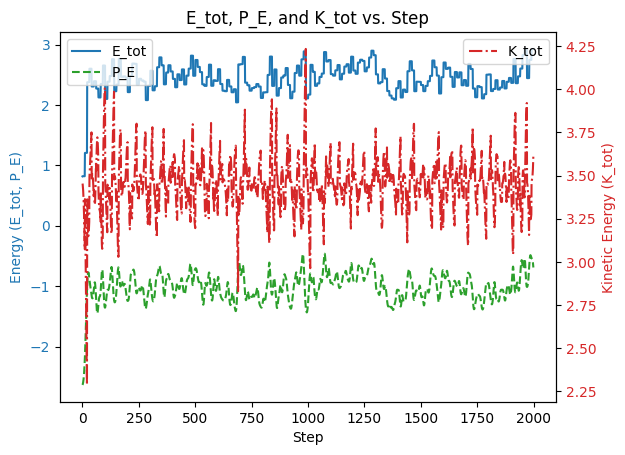

In [22]:
step = stats[:, 0]  
E_tot = stats[:, 1]  
P_E = stats[:, 2]  
K_tot = stats[:, 3]  
T     = stats[:,4]

fig, ax1 = plt.subplots()

ax1.set_xlabel('Step')
ax1.set_ylabel('Energy (E_tot, P_E)', color='tab:blue')
ax1.plot(step, E_tot, label='E_tot', color='tab:blue', linestyle='-')
ax1.plot(step, P_E, label='P_E', color='tab:green', linestyle='--')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.legend(loc='upper left')

# Create a second y-axis (y2) sharing the same x-axis
ax2 = ax1.twinx()
ax2.set_ylabel('Kinetic Energy (K_tot)', color='tab:red')
ax2.plot(step, K_tot, label='K_tot', color='tab:red', linestyle='-.')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.legend(loc='upper right')

# Add a title and display the plot
plt.title('E_tot, P_E, and K_tot vs. Step')
plt.show()